# Analyzing Graduate Admittance: 
### Variable Effect, Feature Creation, and Feature Selection 

This dataset was taken from a Kaggle database called [Graduate Admissions]('https://www.kaggle.com/mohansacharya/graduate-admissions'). 

According to the author: "The dataset contains several parameters which are considered important during the application for Masters Programs. The parameters included are:"
1. GRE Scores (out of 340) [continuous ratio]
2. TOEFL Scores (out of 120) [continuous ratio]
3. University Rating (out of 5) [categorical]
4. Statement of Purpose (out of 5) [continuous ratio]
5. Letter of Recommendation Strength (out of 5) [continuous ratio]
6. Undergraduate GPA (out of 10) [continuous ratio]
7. Research Experience (either 0 or 1) [categorical]
8. Chance of Admit (ranging from 0 to 1)" [continuous ratio]

In [31]:
import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.formula.api as sm
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier

import featuretools as ft

In [2]:
df = pd.read_csv('Admission_Predict_Ver1.1.csv')
df.columns = ['number', 'gre','toefl','uni_rating','sop','lor','gpa','research','admit_chance']
df.head()

,number,gre,toefl,uni_rating,sop,lor,gpa,research,admit_chance
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [3]:
len(df)

500

## I. Exploring Variables Affecting Chance of Admittance
### A. Univariate Explorations of the Data

In [4]:
df.isnull().sum()

number          0
gre             0
toefl           0
uni_rating      0
sop             0
lor             0
gpa             0
research        0
admit_chance    0
dtype: int64

In [5]:
df.describe()

,number,gre,toefl,uni_rating,sop,lor,gpa,research,admit_chance
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,500.000000,500.000000,500.00000
mean,250.500000,316.472000,107.192000,3.114000,3.374000,3.48400,8.576440,0.560000,0.72174
std,144.481833,11.295148,6.081868,1.143512,0.991004,0.92545,0.604813,0.496884,0.14114
min,1.000000,290.000000,92.000000,1.000000,1.000000,1.00000,6.800000,0.000000,0.34000
25%,125.750000,308.000000,103.000000,2.000000,2.500000,3.00000,8.127500,0.000000,0.63000
50%,250.500000,317.000000,107.000000,3.000000,3.500000,3.50000,8.560000,1.000000,0.72000
75%,375.250000,325.000000,112.000000,4.000000,4.000000,4.00000,9.040000,1.000000,0.82000
max,500.000000,340.000000,120.000000,5.000000,5.000000,5.00000,9.920000,1.000000,0.97000


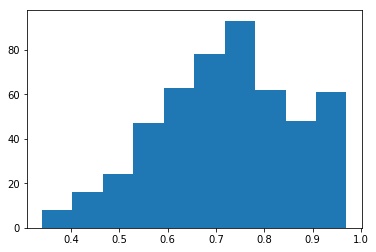

In [6]:
plt.hist(df.admit_chance)
plt.show()

#### Observing OLS Regression Correlations between Variables

In [7]:
X = df[['gre','toefl','uni_rating','sop','lor','gpa','research']]
Y = df.admit_chance

regr = linear_model.LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)
print('\nR-Squared: \n', regr.score(X, Y))

Intercept: 
 -1.2757250829969877
Coefficients: 
 [0.00185851 0.00277797 0.00594137 0.00158614 0.01685874 0.11838505
 0.02430748]

R-Squared: 
 0.8219007395178417


### B. Bivariate Explorations of the Data

In [8]:
df.head()

,number,gre,toefl,uni_rating,sop,lor,gpa,research,admit_chance
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


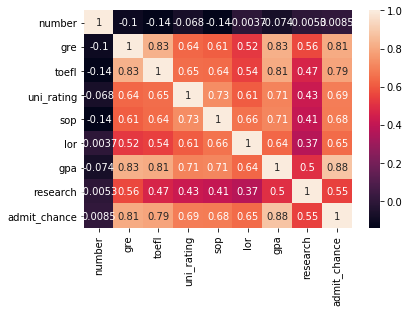

In [9]:
sns.heatmap(df.corr(), annot=True)

In [10]:
normalized_df=(df-df.mean())/df.std()
normalized_df.drop(['uni_rating','research'],axis=1)
normalized_df['uni_rating'] = df.uni_rating
normalized_df['research'] = df.research
normalized_df.head()

,number,gre,toefl,uni_rating,sop,lor,gpa,research,admit_chance
0,-1.726861,1.817417,1.777086,4,1.136222,1.097845,1.775029,1,1.404701
1,-1.719939,0.666481,-0.031569,4,0.631683,1.097845,0.485373,1,0.271078
2,-1.713018,-0.041788,-0.524839,3,-0.377395,0.017289,-0.953088,1,-0.012328
3,-1.706097,0.489414,0.461700,3,0.127144,-1.063267,0.154692,1,0.554483
4,-1.699176,-0.218855,-0.689262,2,-1.386473,-0.522989,-0.605873,0,-0.508288


c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\axisgrid.py:715: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


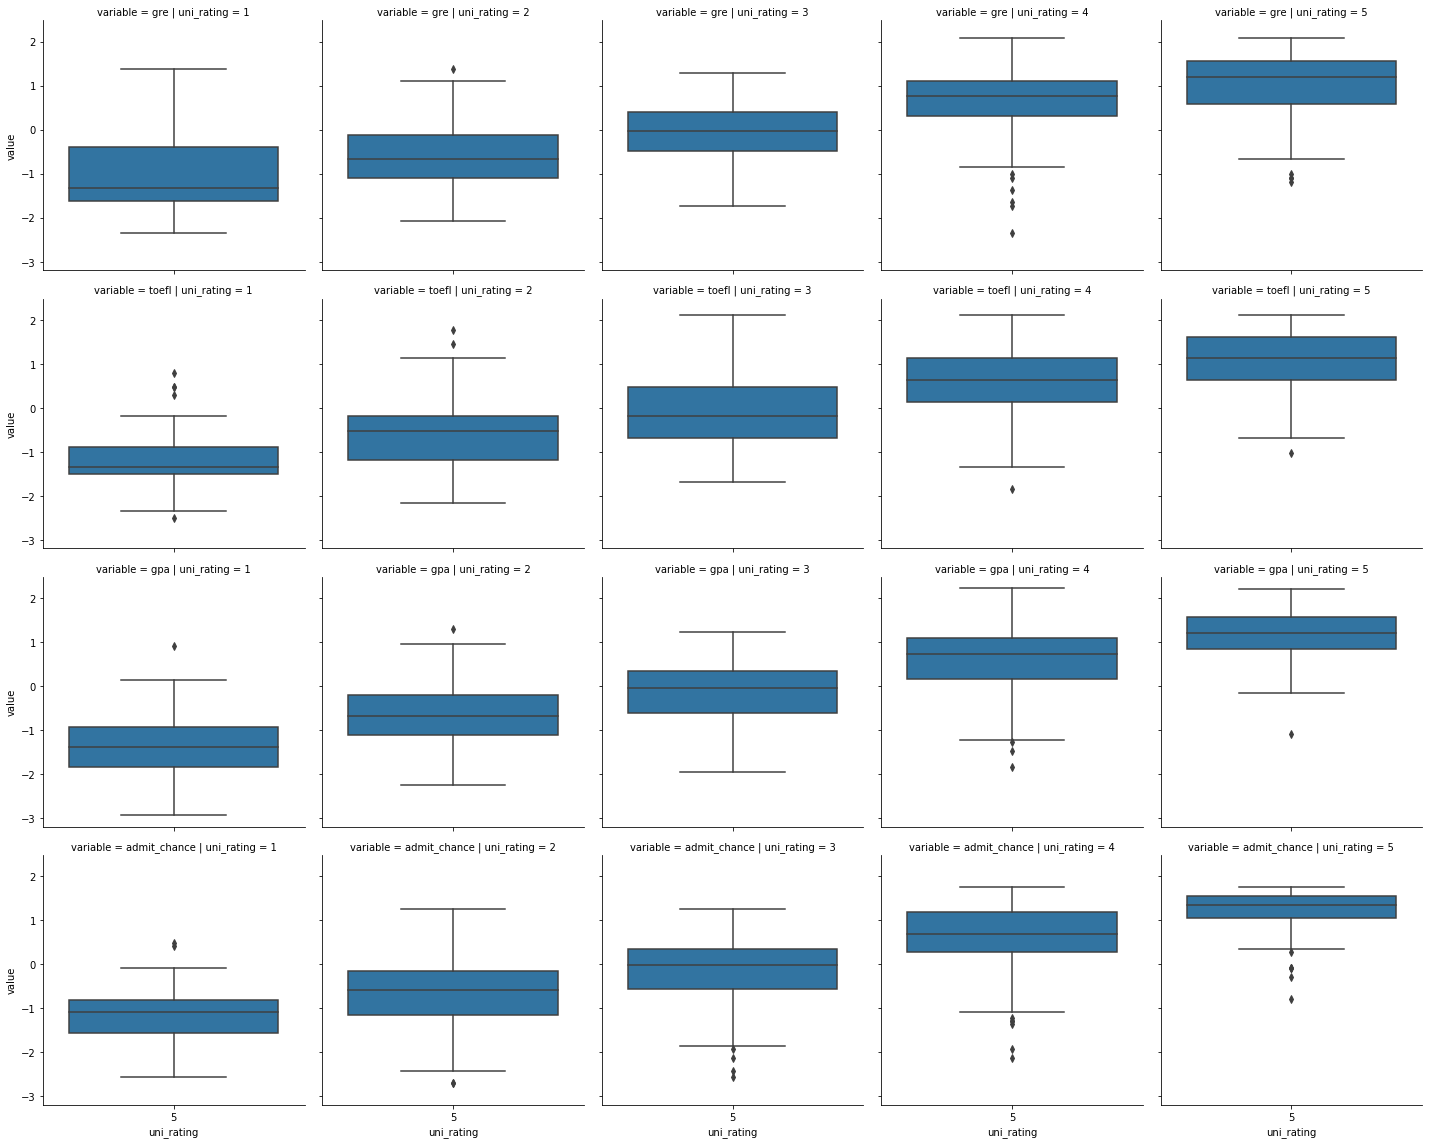

In [11]:
df_long = pd.melt(normalized_df.drop(['number','research','sop','lor'],axis=1), id_vars=['uni_rating'])
g = sns.FacetGrid(df_long, col='uni_rating', row='variable', height=4, aspect=1)
g = g.map(sns.boxplot, 'uni_rating', 'value')

## II. Creation of Ten New Features

In [13]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(['admit_chance','number'], axis=1),
                                                   df['admit_chance'],
                                                   test_size=.33,
                                                   random_state=42)
wide_x = pd.get_dummies(X_train, drop_first=True)
wide_x.head()

,gre,toefl,uni_rating,sop,lor,gpa,research
471,311,103,3,2.0,4.0,8.09,0
26,322,109,5,4.5,3.5,8.80,0
7,308,101,2,3.0,4.0,7.90,0
453,319,103,3,2.5,4.0,8.76,1
108,331,116,5,5.0,5.0,9.38,1


In [14]:
# Shows that all columns have a high enough variance
selector = VarianceThreshold(threshold=0.8 * (1 - .8)).fit(wide_x)
wide_x[wide_x.columns[selector.get_support()]].head()

,gre,toefl,uni_rating,sop,lor,gpa,research
471,311,103,3,2.0,4.0,8.09,0
26,322,109,5,4.5,3.5,8.80,0
7,308,101,2,3.0,4.0,7.90,0
453,319,103,3,2.5,4.0,8.76,1
108,331,116,5,5.0,5.0,9.38,1


### Features 1, 2, and 3

In [15]:
# The methods based on F-test estimate the degree of linear dependency between two random variables
selector = SelectKBest(score_func=f_regression, k=3).fit(wide_x, y_train)
wide_x[wide_x.columns[selector.get_support()]].head()

# The SelectKBest report confirms the correlation in the heatmap above showing GRE, TOEFL, and GPA as most correlated variables

,gre,toefl,gpa
471,311,103,8.09
26,322,109,8.80
7,308,101,7.90
453,319,103,8.76
108,331,116,9.38


### Feature 4

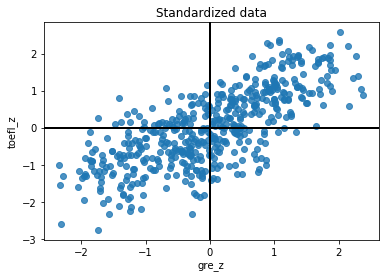

In [16]:
df_pca = df.loc[:, ['gre', 'toefl']]

df_pca['gre_z'] = (df_pca['gre'] - df_pca['gre'].mean()) / df_pca['gre'].std()
df_pca['toefl_z'] = (df_pca['toefl'] - df_pca['toefl'].mean()) / df_pca['toefl'].std()

t = sns.regplot(
    'gre_z',
    'toefl_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False)

t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

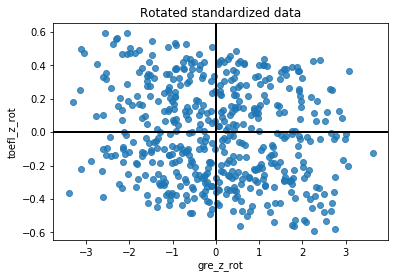

In [17]:
df_pca['gre_z_rot'] = math.cos(40) * df_pca['gre_z'] - math.sin(40) * df_pca['gre_z']
df_pca['toefl_z_rot'] = math.sin(40) * df_pca['toefl_z'] + math.cos(40) * df_pca['toefl_z']

t = sns.regplot(
    'gre_z_rot',
    'toefl_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

In [18]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = df['admit_chance'].values.reshape(-1, 1)

#Adding column to DataFrame for later use in StatsModel
df['gre_z_rot'] = df_pca['gre_z_rot']
X = df[['gpa','gre_z_rot']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.15646397 -0.02565007]]

Intercept: 
 [-0.62016388]

R-squared:
0.7995882998588074


### Feature 5

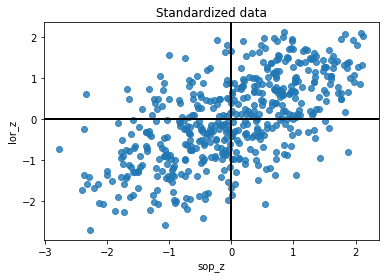

In [19]:
df_pca = df.loc[:, ['sop', 'lor']]

df_pca['sop_z'] = (df_pca['sop'] - df_pca['sop'].mean()) / df_pca['sop'].std()
df_pca['lor_z'] = (df_pca['lor'] - df_pca['lor'].mean()) / df_pca['lor'].std()

t = sns.regplot(
    'sop_z',
    'lor_z',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False)

t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Standardized data')
plt.show()

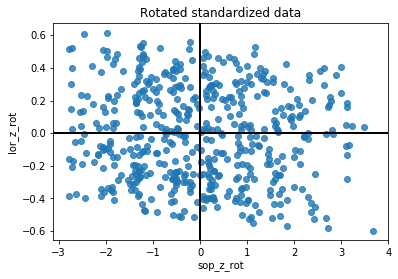

In [20]:
df_pca['sop_z_rot'] = math.cos(40) * df_pca['sop_z'] - math.sin(40) * df_pca['sop_z']
df_pca['lor_z_rot'] = math.sin(40) * df_pca['lor_z'] + math.cos(40) * df_pca['lor_z']

t = sns.regplot(
    'sop_z_rot',
    'lor_z_rot',
    df_pca,
    x_jitter=.49,
    y_jitter=.49,
    fit_reg=False
)
t.axhline(0, color='k', linestyle='-', linewidth=2)
t.axvline(0, color='k', linestyle='-', linewidth=2)
t.axes.set_title('Rotated standardized data')
plt.show()

In [21]:
#Adding column to DataFrame for later use in StatsModel
df['sop_z_rot'] = df_pca['sop_z_rot']
# Y is listed as df.admit_chance
X = df[['gpa','sop_z_rot']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.1871314  -0.01130133]]

Intercept: 
 [-0.88318123]

R-squared:
0.784952234796065


### Feature 6

In [22]:
uni_1 = df[df.uni_rating == 1]
uni_2 = df[df.uni_rating == 2]
uni_3 = df[df.uni_rating == 3]
uni_4 = df[df.uni_rating == 4]
uni_5 = df[df.uni_rating == 5]

In [23]:
print(uni_1.drop(['number','uni_rating','gre_z_rot','sop_z_rot'], axis=1).describe())
print(uni_2.drop(['number','uni_rating','gre_z_rot','sop_z_rot'], axis=1).describe())
print(uni_3.drop(['number','uni_rating','gre_z_rot','sop_z_rot'], axis=1).describe())
print(uni_4.drop(['number','uni_rating','gre_z_rot','sop_z_rot'], axis=1).describe())
print(uni_5.drop(['number','uni_rating','gre_z_rot','sop_z_rot'], axis=1).describe())

              gre       toefl        sop        lor        gpa   research  \
count   34.000000   34.000000  34.000000  34.000000  34.000000  34.000000   
mean   304.911765  100.205882   1.941176   2.426471   7.798529   0.294118   
std      9.394930    4.903798   0.715253   0.760107   0.476338   0.462497   
min    290.000000   92.000000   1.000000   1.000000   6.800000   0.000000   
25%    298.250000   98.000000   1.500000   2.000000   7.470000   0.000000   
50%    301.500000   99.000000   2.000000   2.250000   7.740000   0.000000   
75%    312.000000  101.750000   2.375000   3.000000   8.010000   1.000000   
max    332.000000  112.000000   3.500000   4.000000   9.120000   1.000000   

       admit_chance  
count     34.000000  
mean       0.562059  
std        0.099446  
min        0.360000  
25%        0.502500  
50%        0.570000  
75%        0.607500  
max        0.790000  
              gre       toefl         sop         lor         gpa    research  \
count  126.000000  126.0000

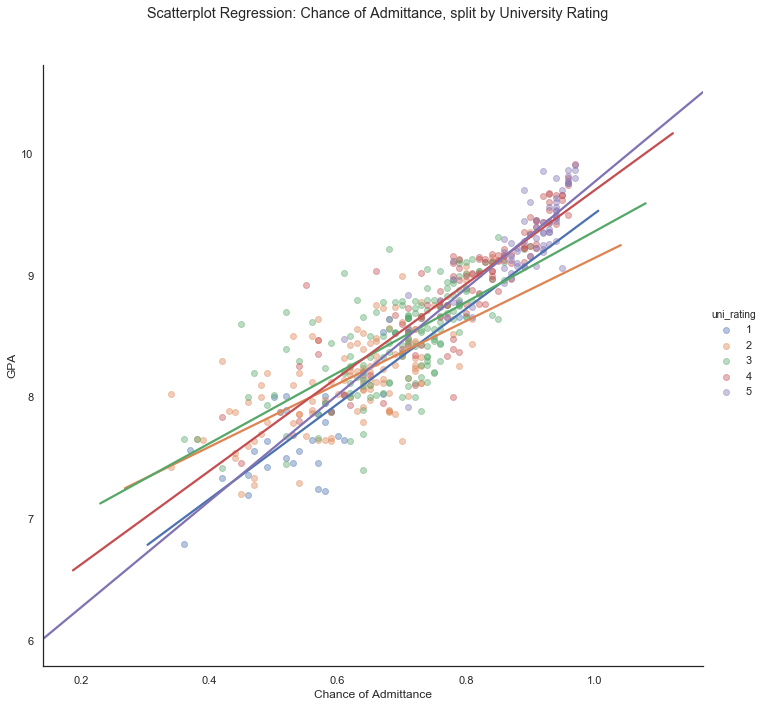

In [24]:
sns.set(style="white")

g = sns.lmplot(y='gpa', 
               x='admit_chance',
               hue='uni_rating',
               data=df, # Data.
               fit_reg=True,
               ci=False,
               scatter_kws={'alpha':0.4},
              height=10)
g.set_ylabels("GPA")
g.set_xlabels("Chance of Admittance")
plt.suptitle('Scatterplot Regression: Chance of Admittance, split by University Rating')
plt.subplots_adjust(top=0.9)
plt.show()

### Feature 7

c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\seaborn\categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


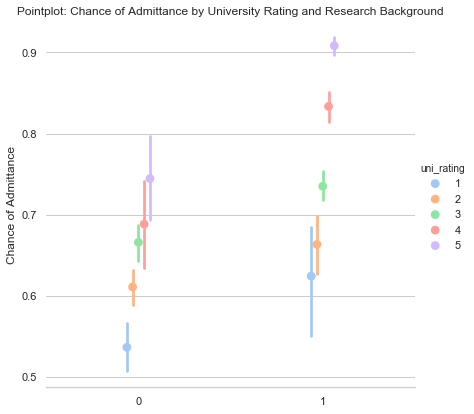

In [39]:
sns.set(style="whitegrid")

g = sns.factorplot(x="research", y="admit_chance", hue="uni_rating", data=df,
                   size=6, kind="point", palette="pastel",ci=95,dodge=True,join=False)
g.despine(left=True)
g.set_ylabels("Chance of Admittance")
g.set_xlabels("")
plt.title('Pointplot: Chance of Admittance by University Rating and Research Background')
plt.show()

### Features 8, 9, and 10

In [77]:
# creating and entity set 'es'
es = ft.EntitySet(id = 'df')

# adding a dataframe 
es.entity_from_dataframe(entity_id = 'data', dataframe = df, index = 'index')

feature_matrix, feature_defs = ft.dfs(entityset = es, target_entity = 'data',
                                      trans_primitives = ['add_numeric', 'multiply_numeric'])
feature_matrix.head()

,id,number,gre,toefl,uni_rating,sop,lor,gpa,research,admit_chance,...,sop + sop_z_rot * uni_rating,gre_z_rot + uni_rating * sop_z_rot + uni_rating,admit_chance + sop_z_rot * number + research,gre + sop_z_rot * gre + uni_rating,gpa + gre_z_rot * gre_z_rot + research,gpa * number + toefl,admit_chance + sop * id + sop,gpa + sop * gre + number,admit_chance + research * lor + sop_z_rot,gre + number * id + research
index,,,,,,,,,,,,,,,,,,,,,
0,0,1,337,118,4,4.5,4.5,9.65,1,0.92,...,11.582386,3.434599,-1.368807,114369.898407,-11.095125,1148.35,24.39,4782.70,5.559545,338
1,1,2,324,107,4,4.0,4.5,8.87,1,0.76,...,12.432126,9.507142,-0.395906,105979.434315,0.466972,966.83,23.80,4195.62,6.350135,652
2,2,3,316,104,3,3.0,3.5,8.00,1,0.72,...,10.598704,10.807168,5.011605,100973.995527,8.534541,856.00,18.60,3509.00,6.936590,957
3,3,4,322,110,3,3.5,2.5,8.67,1,0.80,...,9.961399,6.512239,3.102332,104591.651578,2.464871,988.38,27.95,3967.42,4.176840,1304
4,4,5,314,103,2,2.0,3.0,8.21,0,0.65,...,7.915542,9.138630,13.038856,99842.655709,2.632676,886.68,15.90,3256.99,3.222551,1276


In [59]:
from sklearn import preprocessing
from sklearn import utils

In [55]:
X_train, X_test, y_train, y_test = train_test_split(feature_matrix.drop('admit_chance', axis=1),
                                                   feature_matrix['admit_chance'],
                                                   test_size=.33,
                                                   random_state=42)

In [66]:
lab_enc = preprocessing.LabelEncoder()
encoded_y_train = lab_enc.fit_transform(y_train)

In [67]:
wide_x = pd.get_dummies(X_train, drop_first=True)
wide_x.head()

,number,gre,toefl,uni_rating,sop,lor,gpa,research,gre_z_rot,sop_z_rot,...,sop + sop_z_rot * sop_z_rot + toefl,admit_chance + sop * sop + toefl,admit_chance + gre * lor + research,gpa + sop_z_rot * lor + uni_rating,gre + sop * number + toefl,sop + toefl * toefl + uni_rating,gpa + research * gpa + toefl,gre_z_rot + number * research + sop,gpa + gre * uni_rating,gpa + gre * sop
id,,,,,,,,,,,,,,,,,,,,,
471,472,311,103,3,2.0,4.0,8.09,0,0.684076,1.957771,...,415.398848,277.200,1246.56,70.334399,179975.0,11130.0,898.7181,945.368153,957.27,638.18
26,27,322,109,5,4.5,3.5,8.80,0,-0.691077,-1.604403,...,310.974314,597.010,1129.66,61.162570,44404.0,12939.0,1036.6400,118.390153,1654.00,1488.60
7,8,308,101,2,3.0,4.0,7.90,0,1.059118,0.532901,...,358.705723,382.720,1234.72,50.597408,33899.0,10712.0,860.3100,27.177355,631.80,947.70
453,454,319,103,3,2.5,4.0,8.76,1,-0.316035,1.245336,...,390.433841,340.765,1598.65,70.037354,179075.5,11183.0,1090.7776,1587.893876,983.28,819.40
108,109,331,116,5,5.0,5.0,9.38,1,-1.816203,-2.316838,...,305.030289,717.530,1991.58,70.631616,75600.0,14641.0,1301.4444,643.102783,1701.90,1701.90


In [68]:
tree = DecisionTreeClassifier().fit(wide_x, encoded_y_train)

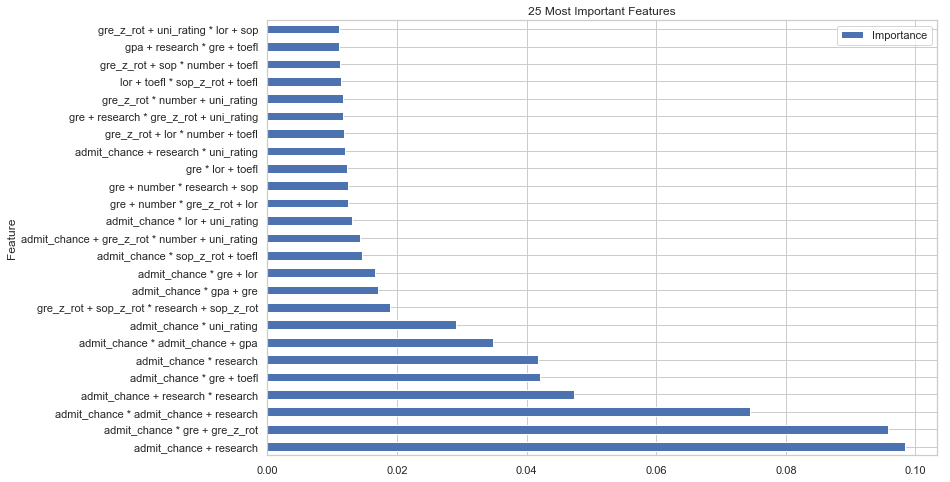

In [79]:
(pd.DataFrame(list(zip(wide_x.columns, tree.feature_importances_)),
            columns=['Feature','Importance'])
 .sort_values('Importance', ascending=False)
 .set_index('Feature')
 .head(25)
 .plot(kind='barh',figsize=(12,8)))
plt.title('25 Most Important Features')
plt.show()

To keep admit_chance as the target dependent variable, we will consider the following three features:
1. gre_z_rot+sop_z_rot*research+sop_z_rot
2. gre*lor+toefl
3. lor+toefl*sop_z_rot+toefl

## III. Selection of Five Best Features

[0.19403527 0.17537619 0.0869206  0.1258059  0.14195361 0.24536799
 0.03054043]


c:\users\paulb\appdata\local\programs\python\python37-32\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


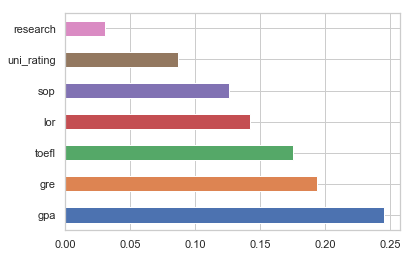

In [27]:
from sklearn import preprocessing

lab_enc = preprocessing.LabelEncoder()
encoded = lab_enc.fit_transform(df.admit_chance)

X = df[['gre','toefl','uni_rating','sop','lor','gpa','research']] #independent columns
y = encoded    #target column
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()

model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns) 
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [28]:
#Observing OLS Regression with features 1, 2, 3, and 5

#Adding column to DataFrame for later use in StatsModel
X = df[['gpa','gre','toefl','sop_z_rot']]
# Y is listed as df.admit_chance
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[ 0.13213715  0.00237651  0.00278257 -0.00869057]]

Intercept: 
 [-1.46189482]

R-squared:
0.8082419354733148


The five major features that we will preserve are:
1. GPA
2. GRE
3. TOEFL
4. sop_z_rot (eigenvector of sop and lor)
5. University Rating